**References:**

1. https://keras.io/api/applications/
2. https://keras.io/guides/transfer_learning/

In [1]:
!nvidia-smi

Wed Feb 10 13:17:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

P100

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/Journal_paper'
! ls

In [18]:
# import the basic libraries
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten, Reshape, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import GlobalAveragePooling2D, Concatenate, Lambda
from keras.optimizers import Adam, RMSprop, Nadam, SGD, Adagrad
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from glob import glob

**NASNetMobile**

SGD

In [19]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [20]:
# add preprocessing layer to the front of NASNetMobile
nasnet_sgd = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [21]:
# don't train existing weights
for layer in nasnet_sgd.layers:
  layer.trainable = False

In [22]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [23]:
# our layers - you can add more if you want
x = Flatten()(nasnet_sgd.output)

In [24]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [25]:
# create a model object
model = Model(inputs=nasnet_sgd.input, outputs=prediction)

In [26]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

In [27]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [28]:
# fit the model
nasnet_sgd = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 204s 14s/step - loss: 32.4413 - accuracy: 0.3850 - val_loss: 53.8091 - val_accuracy: 0.3444
Epoch 2/50
14/14 [==============================] - 10s 731ms/step - loss: 40.5381 - accuracy: 0.4351 - val_loss: 20.9539 - val_accuracy: 0.4500
Epoch 3/50
14/14 [==============================] - 10s 738ms/step - loss: 31.2197 - accuracy: 0.5116 - val_loss: 21.9745 - val_accuracy: 0.6278
Epoch 4/50
14/14 [==============================] - 11s 747ms/step - loss: 23.4376 - accuracy: 0.5618 - val_loss: 8.7576 - val_accuracy: 0.7056
Epoch 5/50
14/14 [==============================] - 10s 727ms/step - loss: 5.2776 - accuracy: 0.7694 - val_loss: 4.5193 - val_accuracy: 0.8000
Epoch 6/50
14/14 [==============================] - 10s 732ms/step - loss: 6.1934 - accuracy: 0.7399 - val_loss: 7.4532 - val_accuracy: 0.6944
Epoch 7/50
14/14 [==============================] - 10s 728ms/step - loss: 10.3731 - accuracy: 0.6827 - val_loss: 5.6342 - val_accuracy:

In [29]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 1.4443
Test accuracy: 0.8722


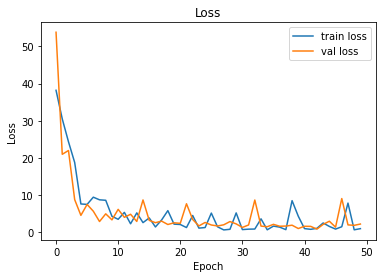

In [30]:
# loss
plt.plot(nasnet_sgd.history['loss'], label='train loss')
plt.plot(nasnet_sgd.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

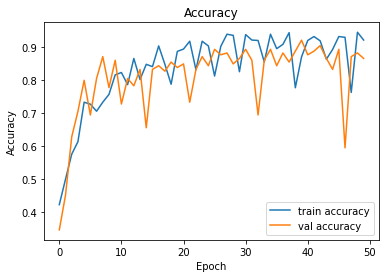

In [31]:
# accuracy
plt.plot(nasnet_sgd.history['accuracy'], label='train accuracy')
plt.plot(nasnet_sgd.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

AdaGrad

In [32]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [33]:
# add preprocessing layer to the front of NASNetMobile
nasnet_adagrad = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [34]:
# don't train existing weights
for layer in nasnet_adagrad.layers:
  layer.trainable = False

In [35]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [36]:
# our layers - you can add more if you want
x = Flatten()(nasnet_adagrad.output)

In [37]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [38]:
# create a model object
model = Model(inputs=nasnet_adagrad.input, outputs=prediction)

In [39]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adagrad',
  metrics=['accuracy']
)

In [40]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [41]:
# fit the model
nasnet_adagrad = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 23s 980ms/step - loss: 3.1327 - accuracy: 0.4058 - val_loss: 1.0355 - val_accuracy: 0.6444
Epoch 2/50
14/14 [==============================] - 10s 788ms/step - loss: 0.7387 - accuracy: 0.6848 - val_loss: 0.5901 - val_accuracy: 0.7389
Epoch 3/50
14/14 [==============================] - 10s 737ms/step - loss: 0.5969 - accuracy: 0.7619 - val_loss: 0.5228 - val_accuracy: 0.7944
Epoch 4/50
14/14 [==============================] - 10s 740ms/step - loss: 0.5459 - accuracy: 0.7817 - val_loss: 0.4685 - val_accuracy: 0.8111
Epoch 5/50
14/14 [==============================] - 10s 734ms/step - loss: 0.4465 - accuracy: 0.8247 - val_loss: 0.5863 - val_accuracy: 0.7444
Epoch 6/50
14/14 [==============================] - 10s 732ms/step - loss: 0.3625 - accuracy: 0.8637 - val_loss: 0.4251 - val_accuracy: 0.8556
Epoch 7/50
14/14 [==============================] - 10s 735ms/step - loss: 0.3719 - accuracy: 0.8660 - val_loss: 0.4208 - val_accuracy: 0.8278

In [43]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.2007
Test accuracy: 0.9167


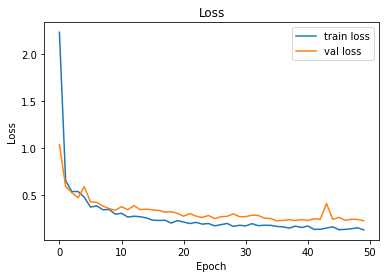

In [44]:
# loss
plt.plot(nasnet_adagrad.history['loss'], label='train loss')
plt.plot(nasnet_adagrad.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

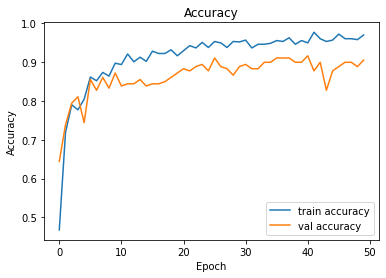

In [45]:
# accuracy
plt.plot(nasnet_adagrad.history['accuracy'], label='train accuracy')
plt.plot(nasnet_adagrad.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

RMSprop

In [46]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [47]:
# add preprocessing layer to the front of NASNetMobile
nasnet_RMSprop = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [48]:
# don't train existing weights
for layer in nasnet_RMSprop.layers:
  layer.trainable = False

In [49]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [50]:
# our layers - you can add more if you want
x = Flatten()(nasnet_RMSprop.output)

In [51]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [52]:
# create a model object
model = Model(inputs=nasnet_RMSprop.input, outputs=prediction)

In [53]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

In [54]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [55]:
# fit the model
nasnet_RMSprop = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 24s 984ms/step - loss: 13.9077 - accuracy: 0.4037 - val_loss: 1.0668 - val_accuracy: 0.7444
Epoch 2/50
14/14 [==============================] - 10s 741ms/step - loss: 2.7800 - accuracy: 0.6558 - val_loss: 5.9774 - val_accuracy: 0.6056
Epoch 3/50
14/14 [==============================] - 11s 747ms/step - loss: 2.9043 - accuracy: 0.6593 - val_loss: 2.4045 - val_accuracy: 0.6500
Epoch 4/50
14/14 [==============================] - 10s 741ms/step - loss: 2.5963 - accuracy: 0.6847 - val_loss: 1.5098 - val_accuracy: 0.7722
Epoch 5/50
14/14 [==============================] - 10s 740ms/step - loss: 1.4864 - accuracy: 0.7824 - val_loss: 2.4013 - val_accuracy: 0.6889
Epoch 6/50
14/14 [==============================] - 10s 734ms/step - loss: 1.2684 - accuracy: 0.7914 - val_loss: 1.9578 - val_accuracy: 0.7722
Epoch 7/50
14/14 [==============================] - 10s 739ms/step - loss: 2.1672 - accuracy: 0.7508 - val_loss: 1.3010 - val_accuracy: 0.805

In [56]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.3704
Test accuracy: 0.9278


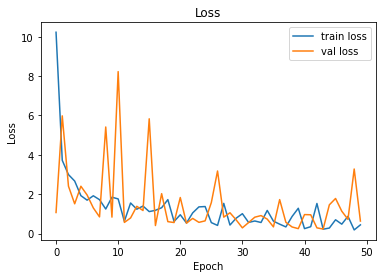

In [57]:
# loss
plt.plot(nasnet_RMSprop.history['loss'], label='train loss')
plt.plot(nasnet_RMSprop.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

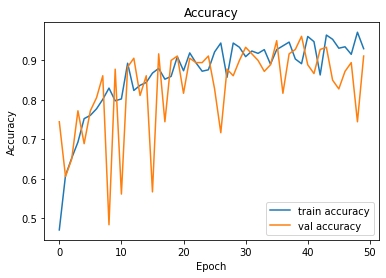

In [58]:
# accuracy
plt.plot(nasnet_RMSprop.history['accuracy'], label='train accuracy')
plt.plot(nasnet_RMSprop.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Nadam

In [59]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [60]:
# add preprocessing layer to the front of NASNetMobile
nasnet_nadam = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [61]:
# don't train existing weights
for layer in nasnet_nadam.layers:
  layer.trainable = False

In [62]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [63]:
# our layers - you can add more if you want
x = Flatten()(nasnet_nadam.output)

In [64]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [65]:
# create a model object
model = Model(inputs=nasnet_nadam.input, outputs=prediction)

In [66]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='nadam',
  metrics=['accuracy']
)

In [67]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [68]:
# fit the model
nasnet_nadam = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 23s 982ms/step - loss: 3.9428 - accuracy: 0.4368 - val_loss: 1.2756 - val_accuracy: 0.6333
Epoch 2/50
14/14 [==============================] - 10s 736ms/step - loss: 1.6225 - accuracy: 0.6518 - val_loss: 1.5794 - val_accuracy: 0.6611
Epoch 3/50
14/14 [==============================] - 10s 735ms/step - loss: 1.1035 - accuracy: 0.7466 - val_loss: 0.7142 - val_accuracy: 0.7889
Epoch 4/50
14/14 [==============================] - 10s 735ms/step - loss: 0.8687 - accuracy: 0.8066 - val_loss: 1.0207 - val_accuracy: 0.7722
Epoch 5/50
14/14 [==============================] - 10s 743ms/step - loss: 0.8431 - accuracy: 0.8176 - val_loss: 1.3184 - val_accuracy: 0.7389
Epoch 6/50
14/14 [==============================] - 10s 739ms/step - loss: 0.8289 - accuracy: 0.7985 - val_loss: 1.0017 - val_accuracy: 0.7889
Epoch 7/50
14/14 [==============================] - 10s 733ms/step - loss: 0.8233 - accuracy: 0.8607 - val_loss: 0.4105 - val_accuracy: 0.8833

In [69]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.3125
Test accuracy: 0.9500


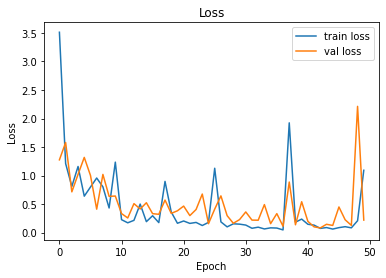

In [70]:
# loss
plt.plot(nasnet_nadam.history['loss'], label='train loss')
plt.plot(nasnet_nadam.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

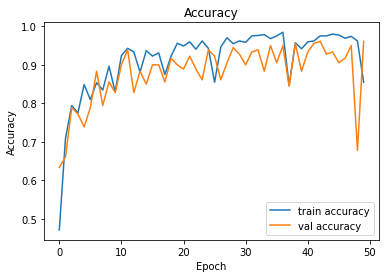

In [71]:
# accuracy
plt.plot(nasnet_nadam.history['accuracy'], label='train accuracy')
plt.plot(nasnet_nadam.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Adam

In [72]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [73]:
# add preprocessing layer to the front of NASNetMobile
nasnet_adam = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [74]:
# don't train existing weights
for layer in nasnet_adam.layers:
  layer.trainable = False

In [75]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [76]:
# our layers - you can add more if you want
x = Flatten()(nasnet_adam.output)

In [77]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [78]:
# create a model object
model = Model(inputs=nasnet_adam.input, outputs=prediction)

In [ ]:
# view the structure of the model
#model.summary()

In [79]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [80]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [81]:
# fit the model
nasnet_adam = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 23s 985ms/step - loss: 5.3724 - accuracy: 0.4086 - val_loss: 1.8163 - val_accuracy: 0.6278
Epoch 2/50
14/14 [==============================] - 10s 735ms/step - loss: 1.7302 - accuracy: 0.6381 - val_loss: 1.4273 - val_accuracy: 0.6667
Epoch 3/50
14/14 [==============================] - 11s 745ms/step - loss: 0.9392 - accuracy: 0.7999 - val_loss: 0.6395 - val_accuracy: 0.8278
Epoch 4/50
14/14 [==============================] - 10s 734ms/step - loss: 0.3887 - accuracy: 0.8836 - val_loss: 0.3926 - val_accuracy: 0.9000
Epoch 5/50
14/14 [==============================] - 10s 736ms/step - loss: 0.3110 - accuracy: 0.8938 - val_loss: 0.5210 - val_accuracy: 0.8500
Epoch 6/50
14/14 [==============================] - 10s 740ms/step - loss: 0.2285 - accuracy: 0.9179 - val_loss: 0.5097 - val_accuracy: 0.8556
Epoch 7/50
14/14 [==============================] - 10s 737ms/step - loss: 0.2413 - accuracy: 0.9282 - val_loss: 0.3148 - val_accuracy: 0.8833

In [83]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0907
Test accuracy: 0.9778


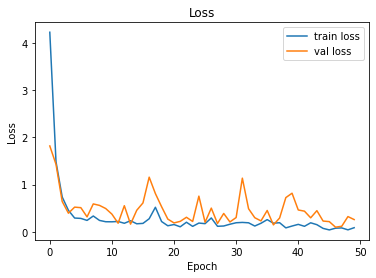

In [85]:
# loss
plt.plot(nasnet_adam.history['loss'], label='train loss')
plt.plot(nasnet_adam.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

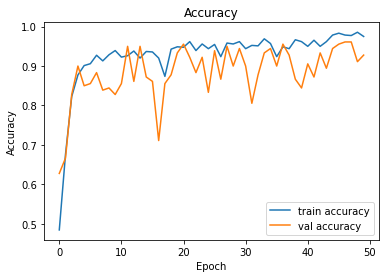

In [86]:
# accuracy
plt.plot(nasnet_adam.history['accuracy'], label='train accuracy')
plt.plot(nasnet_adam.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Adadelta**

In [88]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [89]:
# add preprocessing layer to the front of NASNetMobile
nasnet_adadelta = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [90]:
# don't train existing weights
for layer in nasnet_adadelta.layers:
  layer.trainable = False

In [91]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [92]:
# our layers - you can add more if you want
x = Flatten()(nasnet_adadelta.output)

In [93]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [94]:
# create a model object
model = Model(inputs=nasnet_adadelta.input, outputs=prediction)

In [95]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adadelta',
  metrics=['accuracy']
)

In [96]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [97]:
# fit the model
nasnet_adadelta = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 23s 996ms/step - loss: 1.3985 - accuracy: 0.2956 - val_loss: 1.3637 - val_accuracy: 0.3000
Epoch 2/50
14/14 [==============================] - 10s 733ms/step - loss: 1.3490 - accuracy: 0.3537 - val_loss: 1.3401 - val_accuracy: 0.3000
Epoch 3/50
14/14 [==============================] - 10s 787ms/step - loss: 1.3345 - accuracy: 0.2948 - val_loss: 1.3196 - val_accuracy: 0.3056
Epoch 4/50
14/14 [==============================] - 10s 739ms/step - loss: 1.3622 - accuracy: 0.3060 - val_loss: 1.2993 - val_accuracy: 0.3056
Epoch 5/50
14/14 [==============================] - 10s 735ms/step - loss: 1.2709 - accuracy: 0.3534 - val_loss: 1.2809 - val_accuracy: 0.3333
Epoch 6/50
14/14 [==============================] - 10s 734ms/step - loss: 1.2875 - accuracy: 0.3263 - val_loss: 1.2640 - val_accuracy: 0.3278
Epoch 7/50
14/14 [==============================] - 10s 737ms/step - loss: 1.3186 - accuracy: 0.3041 - val_loss: 1.2460 - val_accuracy: 0.3333

In [98]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.9296
Test accuracy: 0.5611


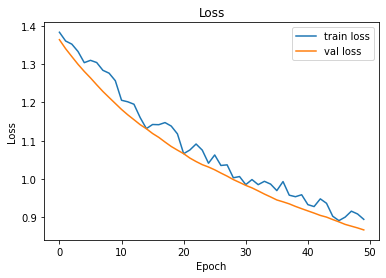

In [99]:
# loss
plt.plot(nasnet_adadelta.history['loss'], label='train loss')
plt.plot(nasnet_adadelta.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

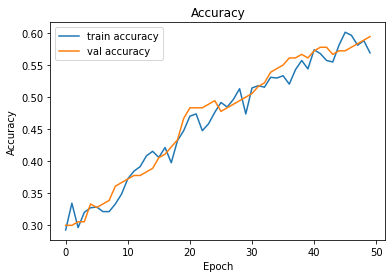

In [100]:
# accuracy
plt.plot(nasnet_adadelta.history['accuracy'], label='train accuracy')
plt.plot(nasnet_adadelta.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Adamax**

In [101]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [102]:
# add preprocessing layer to the front of NASNetMobile
nasnet_adamax = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [103]:
# don't train existing weights
for layer in nasnet_adamax.layers:
  layer.trainable = False

In [104]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [105]:
# our layers - you can add more if you want
x = Flatten()(nasnet_adamax.output)

In [106]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [107]:
# create a model object
model = Model(inputs=nasnet_adamax.input, outputs=prediction)

In [108]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adamax',
  metrics=['accuracy']
)

In [109]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [110]:
# fit the model
nasnet_adamax = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 24s 1s/step - loss: 4.2021 - accuracy: 0.4273 - val_loss: 1.0991 - val_accuracy: 0.6000
Epoch 2/50
14/14 [==============================] - 11s 746ms/step - loss: 0.9015 - accuracy: 0.7091 - val_loss: 0.7238 - val_accuracy: 0.7500
Epoch 3/50
14/14 [==============================] - 11s 754ms/step - loss: 0.5146 - accuracy: 0.8255 - val_loss: 0.6176 - val_accuracy: 0.8000
Epoch 4/50
14/14 [==============================] - 10s 744ms/step - loss: 0.3349 - accuracy: 0.8655 - val_loss: 0.6177 - val_accuracy: 0.7667
Epoch 5/50
14/14 [==============================] - 11s 749ms/step - loss: 0.3007 - accuracy: 0.8901 - val_loss: 0.3830 - val_accuracy: 0.8500
Epoch 6/50
14/14 [==============================] - 11s 760ms/step - loss: 0.2700 - accuracy: 0.8891 - val_loss: 0.3770 - val_accuracy: 0.8667
Epoch 7/50
14/14 [==============================] - 11s 751ms/step - loss: 0.2753 - accuracy: 0.8951 - val_loss: 0.4879 - val_accuracy: 0.8111
Ep

In [111]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.1092
Test accuracy: 0.9778


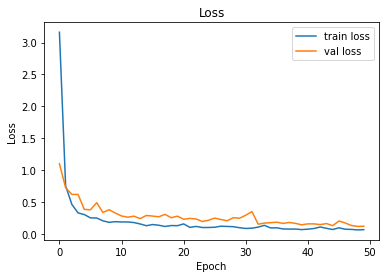

In [112]:
# loss
plt.plot(nasnet_adamax.history['loss'], label='train loss')
plt.plot(nasnet_adamax.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

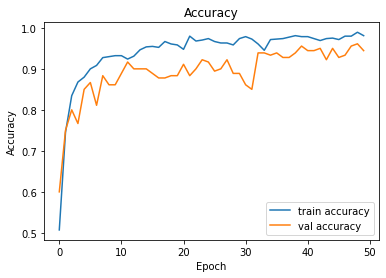

In [113]:
# accuracy
plt.plot(nasnet_adamax.history['accuracy'], label='train accuracy')
plt.plot(nasnet_adamax.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Ftrl

In [114]:
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Journal_paper/Database/train'
valid_path = '/content/gdrive/MyDrive/Journal_paper/Database/valid'
test_path = '/content/gdrive/MyDrive/Journal_paper/Database/test'

In [115]:
# add preprocessing layer to the front of NASNetMobile
nasnet_ftrl = NASNetMobile(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [116]:
# don't train existing weights
for layer in nasnet_ftrl.layers:
  layer.trainable = False

In [117]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Journal_paper/Database/train/*')

In [118]:
# our layers - you can add more if you want
x = Flatten()(nasnet_ftrl.output)

In [119]:
#x = Dense(3, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [120]:
# create a model object
model = Model(inputs=nasnet_ftrl.input, outputs=prediction)

In [121]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='ftrl',
  metrics=['accuracy']
)

In [122]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 64 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [123]:
# fit the model
nasnet_ftrl = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/50
14/14 [==============================] - 24s 1s/step - loss: 3.7852 - accuracy: 0.3678 - val_loss: 0.9229 - val_accuracy: 0.6000
Epoch 2/50
14/14 [==============================] - 11s 749ms/step - loss: 0.8601 - accuracy: 0.6374 - val_loss: 0.7213 - val_accuracy: 0.6889
Epoch 3/50
14/14 [==============================] - 11s 743ms/step - loss: 0.5122 - accuracy: 0.7950 - val_loss: 0.5368 - val_accuracy: 0.8111
Epoch 4/50
14/14 [==============================] - 11s 749ms/step - loss: 0.4201 - accuracy: 0.8532 - val_loss: 0.5252 - val_accuracy: 0.7667
Epoch 5/50
14/14 [==============================] - 11s 746ms/step - loss: 0.3731 - accuracy: 0.8545 - val_loss: 0.4719 - val_accuracy: 0.7944
Epoch 6/50
14/14 [==============================] - 10s 796ms/step - loss: 0.3248 - accuracy: 0.9082 - val_loss: 0.3988 - val_accuracy: 0.8722
Epoch 7/50
14/14 [==============================] - 11s 748ms/step - loss: 0.3213 - accuracy: 0.9084 - val_loss: 0.3708 - val_accuracy: 0.8778
Ep

In [124]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.1962
Test accuracy: 0.9278


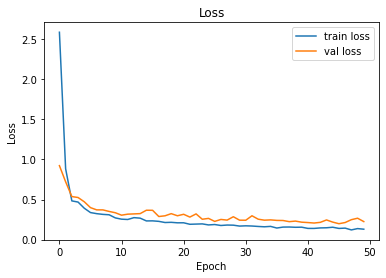

In [125]:
# loss
plt.plot(nasnet_ftrl.history['loss'], label='train loss')
plt.plot(nasnet_ftrl.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

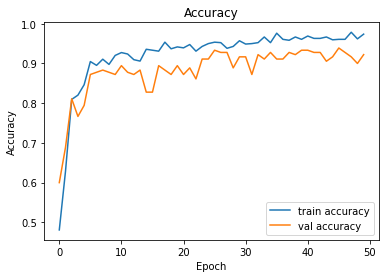

In [126]:
# accuracy
plt.plot(nasnet_ftrl.history['accuracy'], label='train accuracy')
plt.plot(nasnet_ftrl.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 12, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**The accuracy comparison charts:**

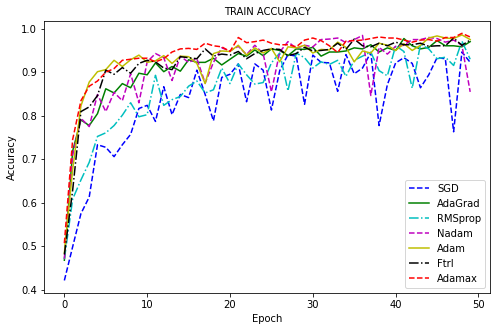

In [127]:
# train accuracy
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(nasnet_sgd.history['accuracy'], '--b', label='SGD')
plt.plot(nasnet_adagrad.history['accuracy'], '-g', label='AdaGrad')
plt.plot(nasnet_RMSprop.history['accuracy'], '-.c', label='RMSprop')
plt.plot(nasnet_nadam.history['accuracy'], '--m', label='Nadam')
plt.plot(nasnet_adam.history['accuracy'], '-y', label='Adam')
#plt.plot(nasnet_adadelta.history['accuracy'], '-.k', label='Adadelta')
plt.plot(nasnet_ftrl.history['accuracy'], '-.k', label='Ftrl')
plt.plot(nasnet_adamax.history['accuracy'], '--r', label='Adamax')
plt.title(label = 'TRAIN ACCURACY', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('train_accuracy_02')

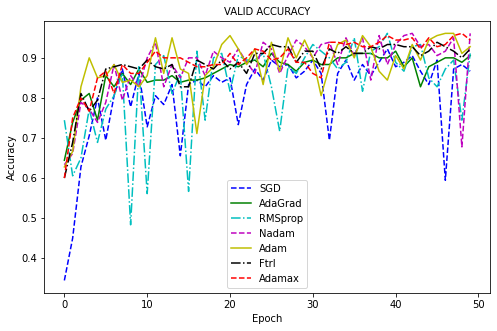

In [128]:
# valid accuracy
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(nasnet_sgd.history['val_accuracy'], '--b', label='SGD')
plt.plot(nasnet_adagrad.history['val_accuracy'], '-g', label='AdaGrad')
plt.plot(nasnet_RMSprop.history['val_accuracy'], '-.c', label='RMSprop')
plt.plot(nasnet_nadam.history['val_accuracy'], '--m', label='Nadam')
plt.plot(nasnet_adam.history['val_accuracy'], '-y', label='Adam')
#plt.plot(nasnet_adadelta.history['val_accuracy'], '-.k', label='Adadelta')
plt.plot(nasnet_ftrl.history['val_accuracy'], '-.k', label='Ftrl')
plt.plot(nasnet_adamax.history['val_accuracy'], '--r', label='Adamax')
plt.title(label = 'VALID ACCURACY', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('valid_accuracy_02')

**The loss comparison charts:**

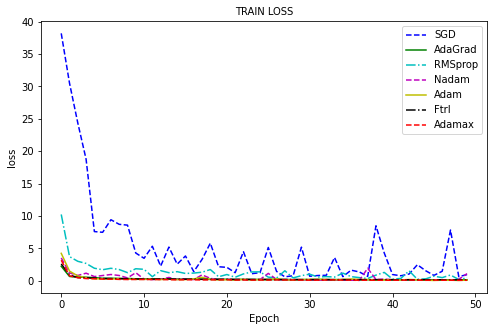

In [129]:
# train loss
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(nasnet_sgd.history['loss'], '--b', label='SGD')
plt.plot(nasnet_adagrad.history['loss'], '-g', label='AdaGrad')
plt.plot(nasnet_RMSprop.history['loss'], '-.c', label='RMSprop')
plt.plot(nasnet_nadam.history['loss'], '--m', label='Nadam')
plt.plot(nasnet_adam.history['loss'], '-y', label='Adam')
#plt.plot(nasnet_adadelta.history['loss'], '-.k', label='Adadelta')
plt.plot(nasnet_ftrl.history['loss'], '-.k', label='Ftrl')
plt.plot(nasnet_adamax.history['loss'], '--r', label='Adamax')
plt.title(label = 'TRAIN LOSS', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
fig.savefig('train_loss_02')

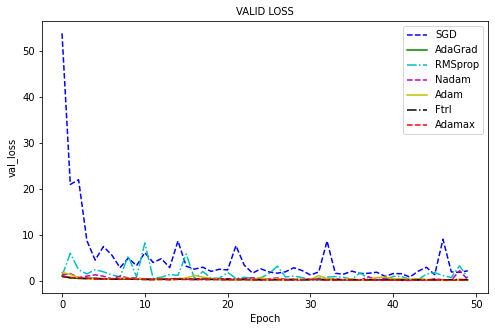

In [130]:
# valid loss
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(nasnet_sgd.history['val_loss'], '--b', label='SGD')
plt.plot(nasnet_adagrad.history['val_loss'], '-g', label='AdaGrad')
plt.plot(nasnet_RMSprop.history['val_loss'], '-.c', label='RMSprop')
plt.plot(nasnet_nadam.history['val_loss'], '--m', label='Nadam')
plt.plot(nasnet_adam.history['val_loss'], '-y', label='Adam')
#plt.plot(nasnet_adadelta.history['val_loss'], '-.k', label='Adadelta')
plt.plot(nasnet_ftrl.history['val_loss'], '-.k', label='Ftrl')
plt.plot(nasnet_adamax.history['val_loss'], '--r', label='Adamax')
plt.title(label = 'VALID LOSS', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.legend()
plt.show()
fig.savefig('valid_loss_02')